In [1]:
import pandas as pd
import sys
sys.path.append('../..')
import sentinel



In [2]:
import os

# Leer todos los archivos CSV en la carpeta ./data/PDTI/
csv_files = [os.path.join('./data/PDTI/', file) for file in os.listdir('./data/PDTI/') if file.endswith('.csv')]

# Concatenar todos los archivos CSV en un solo dataframe
structured_logs = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)#.head(1000)

structured_logs.head()

/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/2344039847.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  structured_logs = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)#.head(1000)


,ingestion_year,ingestion_month,ingestion_day,hrarcb,idnmsg,tipomsg,mes,dia,hrarsp,sistema,...,fncorg,ofcorg,secofc,fncres,codtrn,clvtrn,datos,year,month,day
0,2025,1,22,9455390,,230,1,21,9455390,SVP,...,SVP,276,2,0,206,9.455389e+18,0000000001061438012000000000000000000000000000...,2025,1,22
1,2025,1,22,9455389,,230,1,21,9455389,SVE,...,SVE,276,2,0,385,9.455382e+18,0000000000901450493000000000000000000000000000...,2025,1,22
2,2025,1,22,9455390,,230,1,21,9455390,SVP,...,SVP,276,2,0,369,9.455389e+18,0000000000901210851000000000000000000000000000...,2025,1,22
3,2025,1,22,9455390,,230,1,21,9455390,SVP,...,SVP,276,2,0,410,9.455370e+18,0000000001036935301000000000000000000000000000...,2025,1,22
4,2025,1,22,9455390,,230,1,21,9455390,SVP,...,SVP,276,2,0,3600,9.455371e+18,0000000000093201297000000000000000000000000000...,2025,1,22


In [3]:
#structured_logs[['hrarcb', 'hrarsp', 'hrainicn', 'hrainirs', 'hrafinrs', 'hrafincn', 'dtqhra']].tail()

In [4]:
def convert_to_time(value):
    try:
        value_str = str(value).zfill(8)  # Asegurarse de que el valor tenga 8 dígitos
        if len(value_str) == 7:
            hours = int(value_str[0])
            minutes = int(value_str[1:3])
            seconds = int(value_str[3:5])
        else:
            hours = int(value_str[:2])
            minutes = int(value_str[2:4])
            seconds = int(value_str[4:6])
        return f"{hours:02}:{minutes:02}:{seconds:02}"
    except: 
        return value

columns_to_convert = ['hrarcb', 'hrarsp']

structured_logs['hora'] = structured_logs['hrarcb'].apply(convert_to_time)
structured_logs['hrarsp'] = structured_logs['hrarsp'].apply(convert_to_time)

structured_logs[['hrarcb','hora', 'hrarsp']].head()

,hrarcb,hora,hrarsp
0,9455390,09:45:53,09:45:53
1,9455389,09:45:53,09:45:53
2,9455390,09:45:53,09:45:53
3,9455390,09:45:53,09:45:53
4,9455390,09:45:53,09:45:53


In [5]:
peticiones = structured_logs[structured_logs['tipomsg'] == 220]
respuestas = structured_logs[structured_logs['tipomsg'] == 230]

joined_logs = peticiones.drop(columns=['hrarsp','fncres']).merge(respuestas[['clvtrn', 'hrarsp','fncres']], on='clvtrn', how='left')

In [6]:
print(len(peticiones), len(respuestas),len(joined_logs))

4996177 4987735 9100749


In [7]:
joined_logs.columns

Index(['ingestion_year', 'ingestion_month', 'ingestion_day', 'hrarcb',
       'idnmsg', 'tipomsg', 'mes', 'dia', 'sistema', 'tpooper', 'timeout',
       'nrodtq', 'fecha', 'hrainicn', 'hrainirs', 'hrafinrs', 'hrafincn',
       'nrosec', 'indest', 'indlog', 'indpba', 'eqporg', 'eqpdst', 'lngdta',
       'espacio', 'dtqdia', 'dtqhra', 'fncdem', 'fnctpo', 'fncmsg', 'fnccdg',
       'diseno', 'fncorg', 'ofcorg', 'secofc', 'codtrn', 'clvtrn', 'datos',
       'year', 'month', 'day', 'hora', 'hrarsp', 'fncres'],
      dtype='object')

In [8]:
# Convertir las columnas 'hora' y 'hrarsp' a formato datetime
joined_logs['hora'] = pd.to_datetime(joined_logs['hora'], format='%H:%M:%S')
joined_logs['hrarsp'] = pd.to_datetime(joined_logs['hrarsp'], format='%H:%M:%S')

# Calcular la diferencia en segundos
joined_logs['time_diff_seconds'] = (joined_logs['hrarsp'] - joined_logs['hora']).dt.total_seconds()

joined_logs[['hora', 'hrarsp', 'time_diff_seconds']].head()

,hora,hrarsp,time_diff_seconds
0,1900-01-01 09:45:53,1900-01-01 09:45:53,0.0
1,1900-01-01 09:45:53,1900-01-01 09:45:53,0.0
2,1900-01-01 09:45:53,1900-01-01 09:45:54,1.0
3,1900-01-01 09:45:53,1900-01-01 09:45:53,0.0
4,1900-01-01 09:45:53,1900-01-01 09:45:54,1.0


/Users/jomaver/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


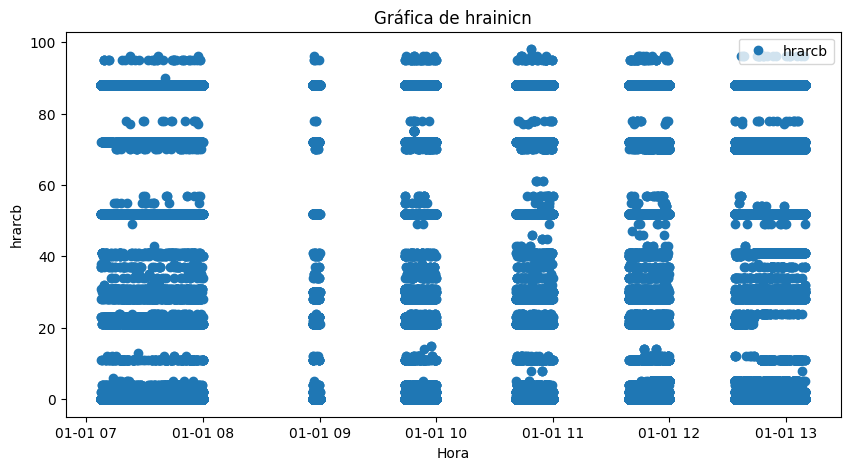

In [9]:
import matplotlib.pyplot as plt

# Convertir la columna 'hrarcb' a datetime y establecerla como índice
structured_logs['hora'] = pd.to_datetime(structured_logs['hora'], format='%H:%M:%S')
#structured_logs.set_index('hrarcb', inplace=True)
#structured_logs.sort_index(inplace=True)
plt.figure(figsize=(10, 5))
plt.plot(joined_logs['hora'], joined_logs['fncres'], 'o',label='hrarcb')
plt.xlabel('Hora')
plt.ylabel('hrarcb')
plt.title('Gráfica de hrainicn')
plt.legend()
plt.show()



In [10]:
from sklearn.feature_selection import VarianceThreshold

# Determinar columnas con muchos valores nulos
null_threshold = 0.5  # Umbral del 50%
columns_with_many_nulls = joined_logs.columns[joined_logs.isnull().mean() > null_threshold]

# Codificación de frecuencia para columnas de tipo string
string_columns = joined_logs.select_dtypes(include=['object']).columns
for column in string_columns:
    freq_encoding = joined_logs[column].value_counts().to_dict()
    joined_logs[column + '_freq'] = joined_logs[column].map(freq_encoding)

# Seleccionar solo las columnas numéricas para calcular la varianza
numeric_columns = joined_logs.select_dtypes(include=['number']).columns
selector = VarianceThreshold(threshold=0.01)  # Umbral de varianza
selector.fit(joined_logs[numeric_columns])
low_variance_columns = numeric_columns[~selector.get_support()]



In [11]:
print("Columnas con muchos valores nulos:", columns_with_many_nulls)
#low_variance_columns = low_variance_columns.drop('fncres_freq')
print("Columnas con casi nula varianza:", low_variance_columns)

Columnas con muchos valores nulos: Index([], dtype='object')
Columnas con casi nula varianza: Index(['ingestion_year_freq', 'ingestion_month_freq', 'ingestion_day_freq',
       'idnmsg_freq', 'tipomsg_freq', 'mes_freq', 'dia_freq', 'tpooper_freq',
       'timeout_freq', 'fecha_freq', 'hrainirs_freq', 'hrafinrs_freq',
       'hrafincn_freq', 'indest_freq', 'indlog_freq', 'indpba_freq',
       'eqporg_freq', 'eqpdst_freq', 'lngdta_freq', 'espacio_freq',
       'dtqdia_freq', 'fncdem_freq', 'fnctpo_freq', 'fncmsg_freq',
       'fnccdg_freq', 'diseno_freq', 'ofcorg_freq', 'secofc_freq', 'year_freq',
       'month_freq', 'day_freq'],
      dtype='object')


In [12]:
low_variance_columns_names = []
for list_ in low_variance_columns:
    low_variance_columns_names += [list_.replace('_freq','')]

In [13]:
joined_logs[low_variance_columns_names]

,ingestion_year,ingestion_month,ingestion_day,idnmsg,tipomsg,mes,dia,tpooper,timeout,fecha,...,fncdem,fnctpo,fncmsg,fnccdg,diseno,ofcorg,secofc,year,month,day
0,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
1,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
2,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
3,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
4,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100744,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
9100745,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
9100746,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22
9100747,2025,1,22,,220,1,21,1,0,121,...,N,4,O,0,,276,1,2025,1,22


In [14]:
joined_logs.columns

Index(['ingestion_year', 'ingestion_month', 'ingestion_day', 'hrarcb',
       'idnmsg', 'tipomsg', 'mes', 'dia', 'sistema', 'tpooper', 'timeout',
       'nrodtq', 'fecha', 'hrainicn', 'hrainirs', 'hrafinrs', 'hrafincn',
       'nrosec', 'indest', 'indlog', 'indpba', 'eqporg', 'eqpdst', 'lngdta',
       'espacio', 'dtqdia', 'dtqhra', 'fncdem', 'fnctpo', 'fncmsg', 'fnccdg',
       'diseno', 'fncorg', 'ofcorg', 'secofc', 'codtrn', 'clvtrn', 'datos',
       'year', 'month', 'day', 'hora', 'hrarsp', 'fncres', 'time_diff_seconds',
       'ingestion_year_freq', 'ingestion_month_freq', 'ingestion_day_freq',
       'hrarcb_freq', 'idnmsg_freq', 'tipomsg_freq', 'mes_freq', 'dia_freq',
       'sistema_freq', 'tpooper_freq', 'timeout_freq', 'nrodtq_freq',
       'fecha_freq', 'hrainicn_freq', 'hrainirs_freq', 'hrafinrs_freq',
       'hrafincn_freq', 'nrosec_freq', 'indest_freq', 'indlog_freq',
       'indpba_freq', 'eqporg_freq', 'eqpdst_freq', 'lngdta_freq',
       'espacio_freq', 'dtqdia_freq', 

In [15]:
# Extraer horas, minutos y segundos de la columna 'hora'
joined_logs['hour'] = joined_logs['hora'].dt.hour
joined_logs['minute'] = joined_logs['hora'].dt.minute
joined_logs['second'] = joined_logs['hora'].dt.second

# Crear la columna 'timestamp' con año, mes, día, hora, minuto y segundo
joined_logs['timestamp'] = pd.to_datetime(joined_logs[['ingestion_year', 'mes', 'dia', 'hour', 'minute', 'second']].rename(columns={'mes': 'month', 'dia': 'day', 'ingestion_year': 'year'}))

joined_logs[['timestamp', 'hora']].head()


,timestamp,hora
0,2025-01-21 09:45:53,1900-01-01 09:45:53
1,2025-01-21 09:45:53,1900-01-01 09:45:53
2,2025-01-21 09:45:53,1900-01-01 09:45:53
3,2025-01-21 09:45:53,1900-01-01 09:45:53
4,2025-01-21 09:45:53,1900-01-01 09:45:53


In [16]:
# Drop columns with low variance, low variance column names, and 'hora'
columns_to_drop = low_variance_columns_names + ['hora']
filtered_logs = joined_logs.drop(columns=columns_to_drop)
filtered_logs = filtered_logs.drop(columns=low_variance_columns)
filtered_logs = filtered_logs.drop(columns=['hrarcb', 'hrarsp',
       'hrainicn',  'dtqhra', 
       'sistema_freq',  'nrodtq_freq', 'hrainicn_freq',
        'nrosec_freq', 'dtqhra_freq', 'fncorg_freq', 'codtrn_freq', 'hour', 'minute', 'second', 'nrosec','hrarcb_freq','fncres_freq'])

filtered_logs.head()

,sistema,nrodtq,fncorg,codtrn,clvtrn,datos,fncres,time_diff_seconds,datos_freq,timestamp
0,SVP,APP,SVP,219,9.455390e+18,0000000001061438012000000000000000000000000000...,0,0.0,1,2025-01-21 09:45:53
1,APP,APP,APP,1638,9.455390e+18,0000000001020765149000000000000000000000000000...,0,0.0,2,2025-01-21 09:45:53
2,APP,APP,APP,1638,9.455390e+18,0000000001020765149000000000000000000000000000...,0,1.0,2,2025-01-21 09:45:53
3,SVP,APP,SVP,208,9.455390e+18,0000000000028559183000000000000000000000000000...,0,0.0,2,2025-01-21 09:45:53
4,SVP,APP,SVP,208,9.455390e+18,0000000000028559183000000000000000000000000000...,0,1.0,2,2025-01-21 09:45:53


In [17]:
filtered_logs.columns

Index(['sistema', 'nrodtq', 'fncorg', 'codtrn', 'clvtrn', 'datos', 'fncres',
       'time_diff_seconds', 'datos_freq', 'timestamp'],
      dtype='object')

In [18]:
# Crear la columna 'respuesta_exitosa'
filtered_logs['respuesta_exitosa'] = (filtered_logs['fncres'] == 0).astype(int)

filtered_logs['respuesta_no_exitosa'] = (filtered_logs['fncres'] != 0).astype(int)

filtered_logs['sin_respuesta'] = (filtered_logs['fncres'].isna()).astype(int)

filtered_logs.head(50)

,sistema,nrodtq,fncorg,codtrn,clvtrn,datos,fncres,time_diff_seconds,datos_freq,timestamp,respuesta_exitosa,respuesta_no_exitosa,sin_respuesta
0,SVP,APP,SVP,219,9.455390e+18,0000000001061438012000000000000000000000000000...,0,0.0,1,2025-01-21 09:45:53,1,0,0
1,APP,APP,APP,1638,9.455390e+18,0000000001020765149000000000000000000000000000...,0,0.0,2,2025-01-21 09:45:53,1,0,0
2,APP,APP,APP,1638,9.455390e+18,0000000001020765149000000000000000000000000000...,0,1.0,2,2025-01-21 09:45:53,1,0,0
3,SVP,APP,SVP,208,9.455390e+18,0000000000028559183000000000000000000000000000...,0,0.0,2,2025-01-21 09:45:53,1,0,0
4,SVP,APP,SVP,208,9.455390e+18,0000000000028559183000000000000000000000000000...,0,1.0,2,2025-01-21 09:45:53,1,0,0
5,SVP,APP,SVP,3700,9.455390e+18,0000000001113675535000000000000000000000000000...,0,0.0,1,2025-01-21 09:45:53,1,0,0
6,SVP,APP,SVP,3700,9.455390e+18,0000000001054540122000000000000000000000000000...,0,0.0,2,2025-01-21 09:45:53,1,0,0
7,SVP,APP,SVP,3700,9.455390e+18,0000000001054540122000000000000000000000000000...,0,1.0,2,2025-01-21 09:45:53,1,0,0
8,APP,APP,APP,1464,9.455391e+18,0000000000041940691000000000000000000000000000...,0,0.0,1,2025-01-21 09:45:53,1,0,0
9,APP,APP,APP,1460,9.455391e+18,0000000001043999531000000000000000000000000000...,0,0.0,2,2025-01-21 09:45:53,1,0,0



    - tipomsg 220 corresponde a tpooper 1 y topomsg 230 = tpooper 2
    - 220 = Petición  
    - 230 = respuesta

In [19]:
filtered_logs_APP = filtered_logs[filtered_logs['nrodtq'] == 'APP']
filtered_logs_APP['time_diff_seconds'].fillna(-100, inplace=True)


/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/4172820518.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_logs_APP['time_diff_seconds'].fillna(-100, inplace=True)
/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/4172820518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_logs_APP['time

In [20]:
filtered_logs['fncres'].value_counts()

fncres
0     8612135
88     384669
52      20144
70      15943
5       10742
2        7559
31       6487
72       5388
21       3075
28       2899
23       2550
30       2401
4        1130
11       1115
41        920
34        380
40        372
37        309
24        255
22        198
95        155
1         118
12         91
35         85
57         72
78         72
3          61
55         50
96         49
75         32
54         24
32         20
38         20
49         20
43         17
77         10
14          8
46          7
8           5
61          5
45          4
15          2
98          2
13          1
47          1
36          1
90          1
6           1
Name: count, dtype: int64

In [21]:
filtered_logs_APP.info()

filtered_logs_APP.fillna(-100, inplace=True)
filtered_logs_APP['fncres'] = filtered_logs_APP['fncres'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 8627806 entries, 0 to 9100748
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   sistema               object        
 1   nrodtq                object        
 2   fncorg                object        
 3   codtrn                object        
 4   clvtrn                float64       
 5   datos                 object        
 6   fncres                object        
 7   time_diff_seconds     float64       
 8   datos_freq            int64         
 9   timestamp             datetime64[ns]
 10  respuesta_exitosa     int64         
 11  respuesta_no_exitosa  int64         
 12  sin_respuesta         int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 921.5+ MB


/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/28367173.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_logs_APP.fillna(-100, inplace=True)
/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/28367173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_logs_APP.fillna(-100, inplace=True)
/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/28367173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

### Agregación de datos String

In [22]:
# Crear una función personalizada para calcular la moda diferente de 0
def mode_different_from_zero(series):
    filtered_values = series[series != 0]
    return filtered_values.mode().iloc[0] if not filtered_values.mode().empty else 0

# Realizar la agregación cada 30 segundos
aggregated_logs_mode = filtered_logs_APP.resample('30S', on='timestamp').agg({
    'fncres': mode_different_from_zero
})

# Renombrar la columna resultante
aggregated_logs_mode.rename(columns={'fncres': 'mode_different_from_zero'}, inplace=True)

aggregated_logs_mode.head()

/var/folders/ck/pscdwm851rb3zr3vrmnv_hwm0000gr/T/ipykernel_89457/209260370.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_logs_mode = filtered_logs_APP.resample('30S', on='timestamp').agg({


,mode_different_from_zero
timestamp,
2025-01-21 07:07:00,88
2025-01-21 07:07:30,88
2025-01-21 07:08:00,88
2025-01-21 07:08:30,88
2025-01-21 07:09:00,88


In [23]:
aggregated_logs_mode.value_counts()

mode_different_from_zero
 0                          425
 88                         300
-100                          1
 31                           1
Name: count, dtype: int64

In [24]:
import sentinel.transformer
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Crear instancia del agregador
aggregator = sentinel.transformer.StringAggregator(filtered_logs_APP, timestamp_column='timestamp')
    
# Definir métricas personalizadas
column_metrics = {
'sistema': ['count'],
'time_diff_seconds':[np.mean, np.sum, np.min, np.max],
'fncres':[np.sum,'mode','nunique', np.mean],
'codtrn':['mode','nunique'],
'respuesta_exitosa':[np.sum],
'respuesta_no_exitosa':[np.sum],
'sin_respuesta':[np.sum],
    }
    
aggregate_logs = aggregator.create_time_aggregation(
        time_window='30s', 
        column_metrics=column_metrics,
    )

aggregate_logs.rename(columns={'sistema_count':'total_events'},inplace=True)
aggregate_logs.columns

Index(['total_events', 'time_diff_seconds_<function mean at 0x120f6dee0>',
       'time_diff_seconds_<function sum at 0x120f68f70>',
       'time_diff_seconds_<function min at 0x120f6d700>',
       'time_diff_seconds_<function max at 0x120f6d5e0>',
       'fncres_<function sum at 0x120f68f70>', 'fncres_mode', 'fncres_nunique',
       'fncres_<function mean at 0x120f6dee0>', 'codtrn_mode',
       'codtrn_nunique', 'respuesta_exitosa_<function sum at 0x120f68f70>',
       'respuesta_no_exitosa_<function sum at 0x120f68f70>',
       'sin_respuesta_<function sum at 0x120f68f70>',
       'avg_time_between_events_seconds', 'min_time_between_events_seconds',
       'max_time_between_events_seconds'],
      dtype='object')

In [25]:
aggregate_logs.columns = ['total_events', 'time_diff_seconds_mean',
       'time_diff_seconds_sum',
       'time_diff_seconds_min',
       'time_diff_seconds_max',
       'fncres_sum', 'fncres_mode', 'fncres_nunique',
       'fncres_mean', 'codtrn_mode',
       'codtrn_nunique', 'num_respuestas_exitosas',
       'num_respuestas_no_exitosas','num_sin_respuesta','avg_time_between_events_seconds',
       'min_time_between_events_seconds', 'max_time_between_events_seconds',
       ]

aggregate_logs['fncres_mode'] = aggregated_logs_mode['mode_different_from_zero']
aggregate_logs.head()

,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,codtrn_nunique,num_respuestas_exitosas,num_respuestas_no_exitosas,num_sin_respuesta,avg_time_between_events_seconds,min_time_between_events_seconds,max_time_between_events_seconds
2025-01-21 07:07:00,401,0.104738,42.0,0.0,1.0,1776,88,3,4.428928,369.0,31,380,21,0,0.002500,0.0,1.0
2025-01-21 07:07:30,9112,0.102063,930.0,0.0,3.0,23050,88,11,2.529631,369.0,59,8830,282,0,0.003183,0.0,1.0
2025-01-21 07:08:00,9086,0.106427,967.0,0.0,3.0,19643,88,12,2.161897,369.0,67,8827,259,0,0.003192,0.0,1.0
2025-01-21 07:08:30,8593,0.105900,910.0,0.0,3.0,19206,88,12,2.235075,369.0,62,8349,244,0,0.003375,0.0,1.0
2025-01-21 07:09:00,9408,0.096726,910.0,0.0,3.0,22135,88,13,2.352785,369.0,61,9129,279,0,0.003083,0.0,1.0


In [26]:
aggregate_logs['tasa_exito']= aggregate_logs['num_respuestas_exitosas']/aggregate_logs['total_events']
aggregate_logs['tasa_falla']= aggregate_logs['num_respuestas_no_exitosas']/aggregate_logs['total_events']
aggregate_logs['tasa_sin_respuesta']= aggregate_logs['num_sin_respuesta']/aggregate_logs['total_events']

In [27]:
aggregate_logs.dropna(inplace=True)
aggregate_logs.head(50)


,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,codtrn_nunique,num_respuestas_exitosas,num_respuestas_no_exitosas,num_sin_respuesta,avg_time_between_events_seconds,min_time_between_events_seconds,max_time_between_events_seconds,tasa_exito,tasa_falla,tasa_sin_respuesta
2025-01-21 07:07:00,401,0.104738,42.0,0.0,1.0,1776,88,3,4.428928,369.0,31,380,21,0,0.002500,0.0,1.0,0.947631,0.052369,0.0
2025-01-21 07:07:30,9112,0.102063,930.0,0.0,3.0,23050,88,11,2.529631,369.0,59,8830,282,0,0.003183,0.0,1.0,0.969052,0.030948,0.0
2025-01-21 07:08:00,9086,0.106427,967.0,0.0,3.0,19643,88,12,2.161897,369.0,67,8827,259,0,0.003192,0.0,1.0,0.971495,0.028505,0.0
2025-01-21 07:08:30,8593,0.105900,910.0,0.0,3.0,19206,88,12,2.235075,369.0,62,8349,244,0,0.003375,0.0,1.0,0.971605,0.028395,0.0
2025-01-21 07:09:00,9408,0.096726,910.0,0.0,3.0,22135,88,13,2.352785,369.0,61,9129,279,0,0.003083,0.0,1.0,0.970344,0.029656,0.0
2025-01-21 07:09:30,9682,0.100083,969.0,0.0,3.0,22761,88,13,2.350857,369.0,64,9393,289,0,0.002996,0.0,1.0,0.970151,0.029849,0.0
2025-01-21 07:10:00,9478,0.096434,914.0,0.0,1.0,26265,88,10,2.771154,369.0,59,9149,329,0,0.003060,0.0,1.0,0.965288,0.034712,0.0
2025-01-21 07:10:30,9454,0.095832,906.0,0.0,3.0,22436,88,13,2.373175,369.0,63,9168,286,0,0.003068,0.0,1.0,0.969748,0.030252,0.0
2025-01-21 07:11:00,9504,0.102168,971.0,0.0,3.0,23456,88,13,2.468013,369.0,61,9212,292,0,0.003052,0.0,1.0,0.969276,0.030724,0.0
2025-01-21 07:11:30,9335,0.101768,950.0,0.0,3.0,25557,88,13,2.737761,369.0,59,9014,321,0,0.003107,0.0,1.0,0.965613,0.034387,0.0


In [28]:
for i in aggregate_logs.columns:
    print(i)

total_events
time_diff_seconds_mean
time_diff_seconds_sum
time_diff_seconds_min
time_diff_seconds_max
fncres_sum
fncres_mode
fncres_nunique
fncres_mean
codtrn_mode
codtrn_nunique
num_respuestas_exitosas
num_respuestas_no_exitosas
num_sin_respuesta
avg_time_between_events_seconds
min_time_between_events_seconds
max_time_between_events_seconds
tasa_exito
tasa_falla
tasa_sin_respuesta


In [29]:
# Crear un rango de tiempo con frecuencia de 1 minuto
#time_range = pd.date_range(start='2025-01-21 00:00:00', end=aggregate_logs.index.max(), freq='30s')
time_range = pd.date_range(start=aggregate_logs.index.min(), end=aggregate_logs.index.max(), freq='30s')
# Crear un nuevo DataFrame con el rango de tiempo
time_df = pd.DataFrame(index=time_range)

# Concatenar el nuevo DataFrame con aggregate_logs
combined_logs = pd.concat([time_df, aggregate_logs], axis=1)

# Rellenar los valores NaN con 0
#combined_logs.fillna(0, inplace=True)
combined_logs = combined_logs.fillna(0)

combined_logs.head(50)

,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,codtrn_nunique,num_respuestas_exitosas,num_respuestas_no_exitosas,num_sin_respuesta,avg_time_between_events_seconds,min_time_between_events_seconds,max_time_between_events_seconds,tasa_exito,tasa_falla,tasa_sin_respuesta
2025-01-21 07:07:00,401.0,0.104738,42.0,0.0,1.0,1776.0,88.0,3.0,4.428928,369.0,31.0,380.0,21.0,0.0,0.002500,0.0,1.0,0.947631,0.052369,0.0
2025-01-21 07:07:30,9112.0,0.102063,930.0,0.0,3.0,23050.0,88.0,11.0,2.529631,369.0,59.0,8830.0,282.0,0.0,0.003183,0.0,1.0,0.969052,0.030948,0.0
2025-01-21 07:08:00,9086.0,0.106427,967.0,0.0,3.0,19643.0,88.0,12.0,2.161897,369.0,67.0,8827.0,259.0,0.0,0.003192,0.0,1.0,0.971495,0.028505,0.0
2025-01-21 07:08:30,8593.0,0.105900,910.0,0.0,3.0,19206.0,88.0,12.0,2.235075,369.0,62.0,8349.0,244.0,0.0,0.003375,0.0,1.0,0.971605,0.028395,0.0
2025-01-21 07:09:00,9408.0,0.096726,910.0,0.0,3.0,22135.0,88.0,13.0,2.352785,369.0,61.0,9129.0,279.0,0.0,0.003083,0.0,1.0,0.970344,0.029656,0.0
2025-01-21 07:09:30,9682.0,0.100083,969.0,0.0,3.0,22761.0,88.0,13.0,2.350857,369.0,64.0,9393.0,289.0,0.0,0.002996,0.0,1.0,0.970151,0.029849,0.0
2025-01-21 07:10:00,9478.0,0.096434,914.0,0.0,1.0,26265.0,88.0,10.0,2.771154,369.0,59.0,9149.0,329.0,0.0,0.003060,0.0,1.0,0.965288,0.034712,0.0
2025-01-21 07:10:30,9454.0,0.095832,906.0,0.0,3.0,22436.0,88.0,13.0,2.373175,369.0,63.0,9168.0,286.0,0.0,0.003068,0.0,1.0,0.969748,0.030252,0.0
2025-01-21 07:11:00,9504.0,0.102168,971.0,0.0,3.0,23456.0,88.0,13.0,2.468013,369.0,61.0,9212.0,292.0,0.0,0.003052,0.0,1.0,0.969276,0.030724,0.0
2025-01-21 07:11:30,9335.0,0.101768,950.0,0.0,3.0,25557.0,88.0,13.0,2.737761,369.0,59.0,9014.0,321.0,0.0,0.003107,0.0,1.0,0.965613,0.034387,0.0


### Ventana deslizante 

In [30]:
 # Initialize transformer
transformer =  sentinel.transformer.RollingAgregator(
        window_size=40,
        aggregation_functions=['mean']#,'max','sum'],
    )

    
# Apply transformation
rolling_logs = transformer.fit_transform(combined_logs)#.fillna(0)
rolling_logs.head(50)

,total_events,time_diff_seconds_mean,time_diff_seconds_sum,time_diff_seconds_min,time_diff_seconds_max,fncres_sum,fncres_mode,fncres_nunique,fncres_mean,codtrn_mode,...,codtrn_nunique_rolling_mean,num_respuestas_exitosas_rolling_mean,num_respuestas_no_exitosas_rolling_mean,num_sin_respuesta_rolling_mean,avg_time_between_events_seconds_rolling_mean,min_time_between_events_seconds_rolling_mean,max_time_between_events_seconds_rolling_mean,tasa_exito_rolling_mean,tasa_falla_rolling_mean,tasa_sin_respuesta_rolling_mean
2025-01-21 07:07:00,401.0,0.104738,42.0,0.0,1.0,1776.0,88.0,3.0,4.428928,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:07:30,9112.0,0.102063,930.0,0.0,3.0,23050.0,88.0,11.0,2.529631,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:08:00,9086.0,0.106427,967.0,0.0,3.0,19643.0,88.0,12.0,2.161897,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:08:30,8593.0,0.105900,910.0,0.0,3.0,19206.0,88.0,12.0,2.235075,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:09:00,9408.0,0.096726,910.0,0.0,3.0,22135.0,88.0,13.0,2.352785,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:09:30,9682.0,0.100083,969.0,0.0,3.0,22761.0,88.0,13.0,2.350857,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:10:00,9478.0,0.096434,914.0,0.0,1.0,26265.0,88.0,10.0,2.771154,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:10:30,9454.0,0.095832,906.0,0.0,3.0,22436.0,88.0,13.0,2.373175,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:11:00,9504.0,0.102168,971.0,0.0,3.0,23456.0,88.0,13.0,2.468013,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-21 07:11:30,9335.0,0.101768,950.0,0.0,3.0,25557.0,88.0,13.0,2.737761,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Filtrar solo las columnas que contienen '_rolling_mean'
rolling_mean_columns = [col for col in rolling_logs.columns if '_rolling_' in col]

# Crear un nuevo DataFrame con solo las columnas '_rolling_mean'
rolling_mean_logs = rolling_logs[rolling_mean_columns+['fncres_mode','fncres_nunique']].fillna(0)

rolling_mean_logs.head()

,total_events_rolling_mean,time_diff_seconds_mean_rolling_mean,time_diff_seconds_sum_rolling_mean,time_diff_seconds_min_rolling_mean,time_diff_seconds_max_rolling_mean,fncres_sum_rolling_mean,fncres_mode_rolling_mean,fncres_nunique_rolling_mean,fncres_mean_rolling_mean,codtrn_mode_rolling_mean,...,num_respuestas_no_exitosas_rolling_mean,num_sin_respuesta_rolling_mean,avg_time_between_events_seconds_rolling_mean,min_time_between_events_seconds_rolling_mean,max_time_between_events_seconds_rolling_mean,tasa_exito_rolling_mean,tasa_falla_rolling_mean,tasa_sin_respuesta_rolling_mean,fncres_mode,fncres_nunique
2025-01-21 07:07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,3.0
2025-01-21 07:07:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,11.0
2025-01-21 07:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,12.0
2025-01-21 07:08:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,12.0
2025-01-21 07:09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,13.0


In [32]:
rolling_mean_logs.columns

Index(['total_events_rolling_mean', 'time_diff_seconds_mean_rolling_mean',
       'time_diff_seconds_sum_rolling_mean',
       'time_diff_seconds_min_rolling_mean',
       'time_diff_seconds_max_rolling_mean', 'fncres_sum_rolling_mean',
       'fncres_mode_rolling_mean', 'fncres_nunique_rolling_mean',
       'fncres_mean_rolling_mean', 'codtrn_mode_rolling_mean',
       'codtrn_nunique_rolling_mean', 'num_respuestas_exitosas_rolling_mean',
       'num_respuestas_no_exitosas_rolling_mean',
       'num_sin_respuesta_rolling_mean',
       'avg_time_between_events_seconds_rolling_mean',
       'min_time_between_events_seconds_rolling_mean',
       'max_time_between_events_seconds_rolling_mean',
       'tasa_exito_rolling_mean', 'tasa_falla_rolling_mean',
       'tasa_sin_respuesta_rolling_mean', 'fncres_mode', 'fncres_nunique'],
      dtype='object')

### Isolation Forest

In [33]:
import sentinel.detectors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
X_train = combined_logs
#X_train = aggregate_logs
#X_train = rolling_mean_logs
#X_train = rolling_logs
df = X_train.copy()
X_train_raw = X_train.copy()
# Scale the features in X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#if_detector = IsolationForest(n_estimators=250, random_state=42, contamination=0.1)
if_detector = sentinel.detectors.IsolationForestDetector(n_estimators=250, contamination=0.1, random_state=42)
if_detector.fit(X_train)
predictions = if_detector.predict(X_train)
scores = if_detector.decision_function(X_train)


anomalies = if_detector.get_anomalies(X_train)
#proba = if_detector.predict_proba(X_train)


predictions


array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1

In [34]:

df['anomalies'] = predictions
df['scores'] =  scores*-1

In [35]:
import sentinel.visualization
incidents_df = pd.DataFrame({
    'start_time': [pd.Timestamp('2025-01-21 12:00:00')],
    'end_time': [pd.Timestamp('2025-01-21 13:00:00')],
    'Servicio':'App Personas y Mi Bancolombia'
})
plots_if = sentinel.visualization.AnomalyVisualizer(df,anomaly_col='anomalies', incidents_df=incidents_df)


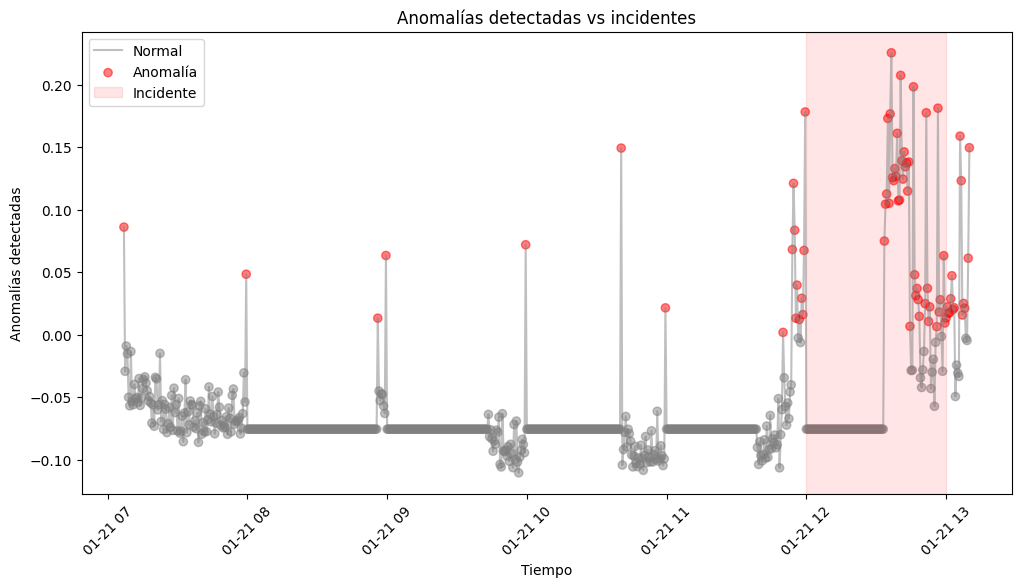

In [36]:
colors = {'normal': 'gray', 'anomaly': 'red', 'incident': 'red'}
plots_if.plot_static(colors=colors)

In [39]:
colors = {'normal': 'blue', 'anomaly': 'red', 'incident': 'blue'}
#cambiar a normal, anomaly, incident
plots_if.plot_dynamic(colors=colors)

In [41]:
combined_logs.to_csv('data/PDTI_Enero_21_2025.csv')

In [42]:
combined_logs.columns

Index(['total_events', 'time_diff_seconds_mean', 'time_diff_seconds_sum',
       'time_diff_seconds_min', 'time_diff_seconds_max', 'fncres_sum',
       'fncres_mode', 'fncres_nunique', 'fncres_mean', 'codtrn_mode',
       'codtrn_nunique', 'num_respuestas_exitosas',
       'num_respuestas_no_exitosas', 'num_sin_respuesta',
       'avg_time_between_events_seconds', 'min_time_between_events_seconds',
       'max_time_between_events_seconds', 'tasa_exito', 'tasa_falla',
       'tasa_sin_respuesta'],
      dtype='object')

In [40]:
anomaly_indices = [i for i, x in enumerate(predictions) if x == -1]
anomaly_indices


[0,
 105,
 218,
 225,
 345,
 427,
 465,
 566,
 574,
 575,
 576,
 577,
 578,
 580,
 582,
 583,
 584,
 585,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 665,
 666,
 667,
 668,
 669,
 670,
 671,
 672,
 673,
 674,
 675,
 678,
 679,
 680,
 681,
 682,
 683,
 688,
 689,
 690,
 691,
 692,
 698,
 699,
 700,
 701,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713,
 718,
 719,
 720,
 721,
 722,
 725,
 726]

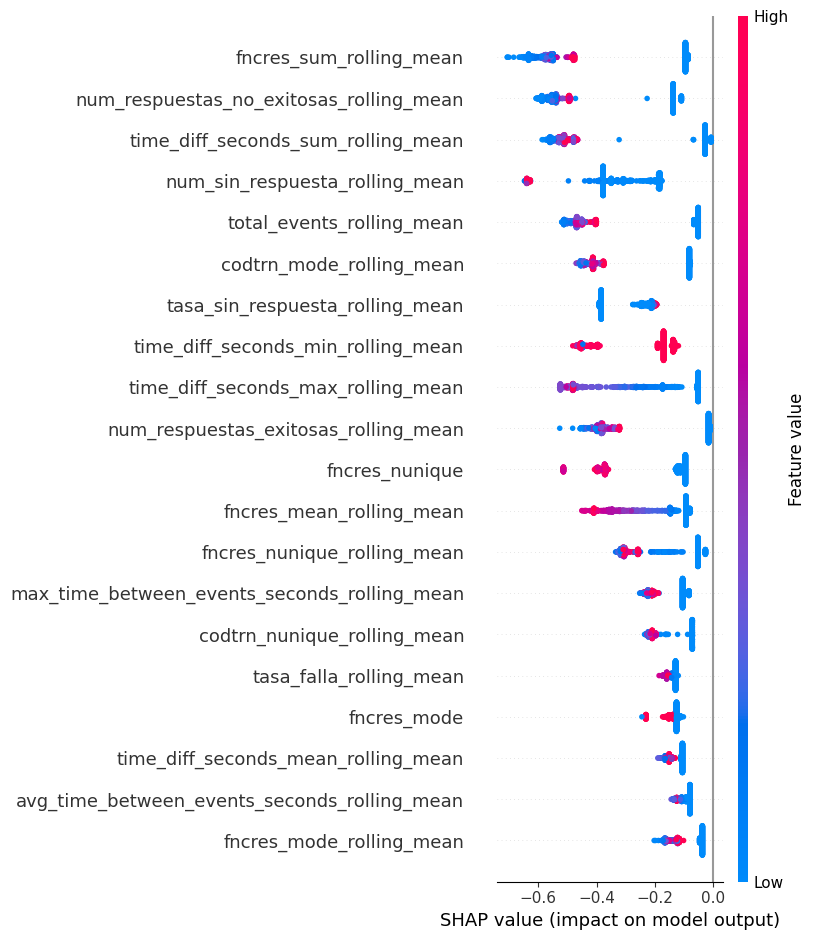

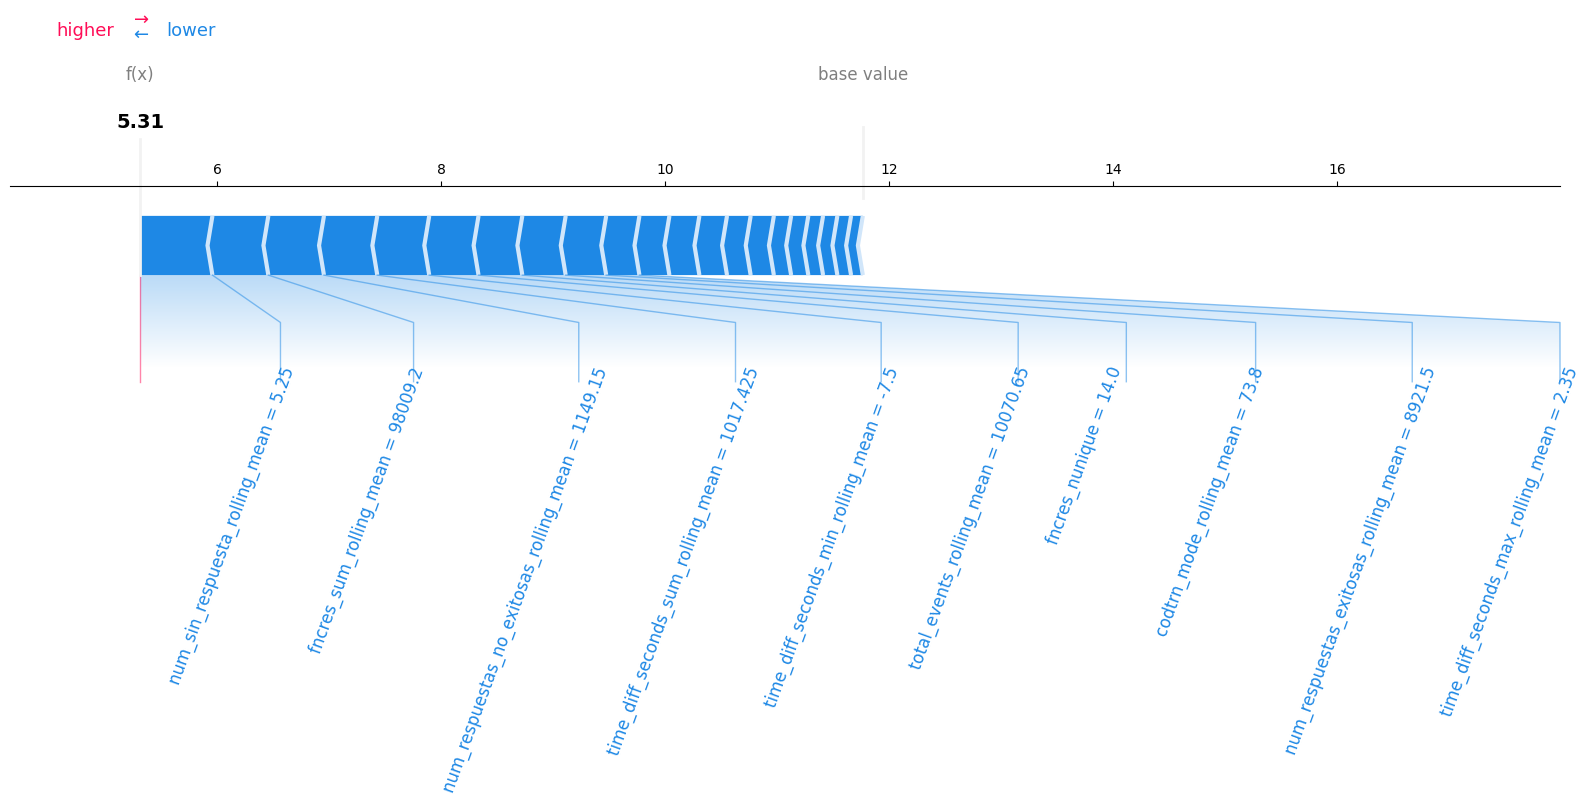

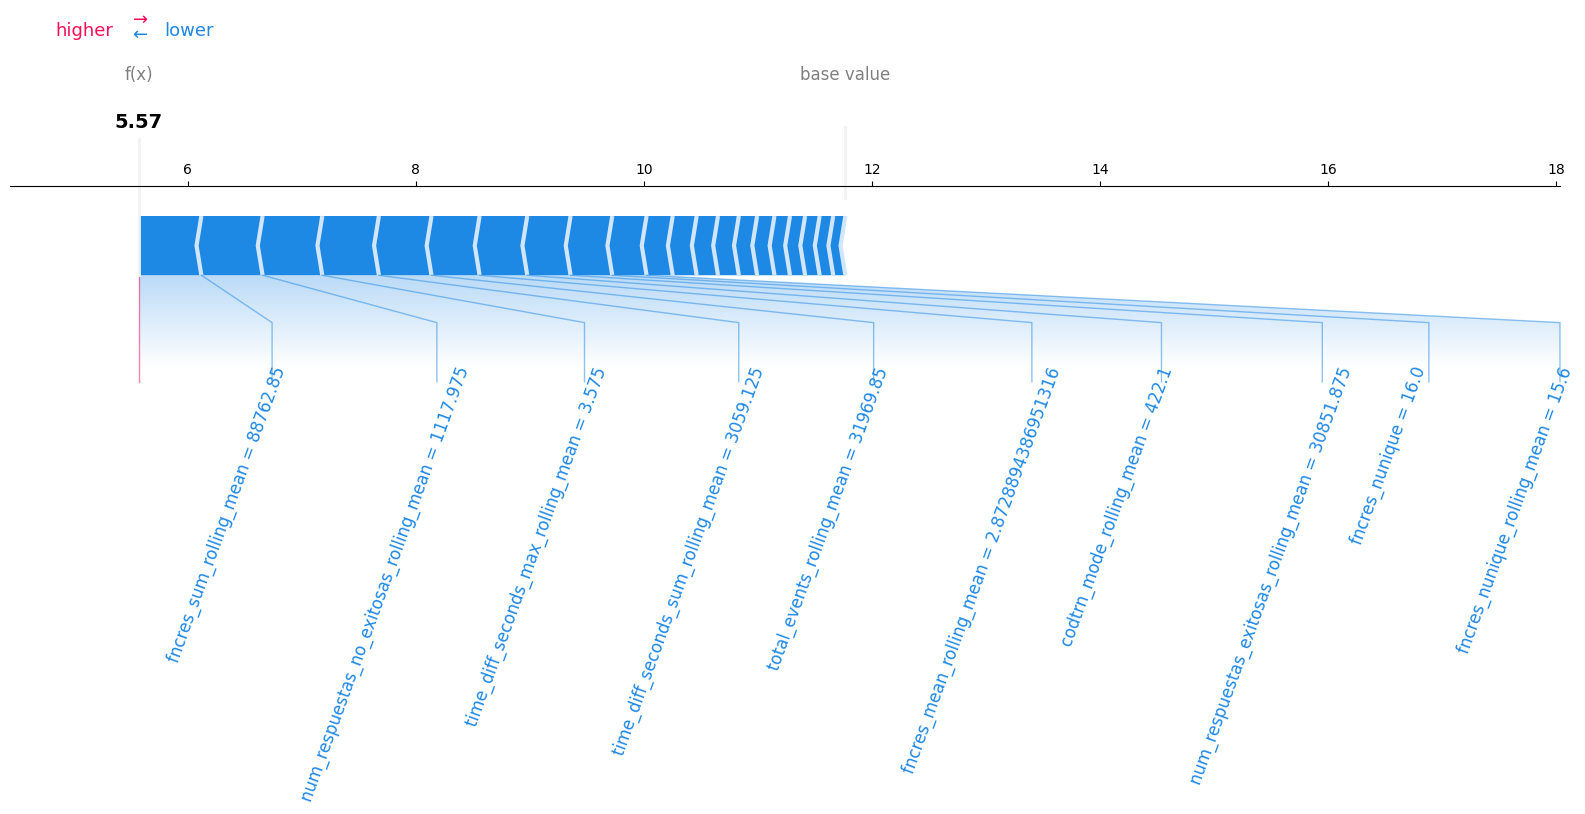

In [103]:
explainer = sentinel.visualization.SHAPVisualizer(if_detector)
explainer.plot_summary(X_train_raw)
explainer.plot_force(X_train_raw,660)
explainer.plot_force(X_train_raw,463)

In [186]:
#!pip install shap
import shap
# Crear un explainer SHAP
explainer = shap.TreeExplainer(if_detector)
shap_values = explainer.shap_values(X_train)

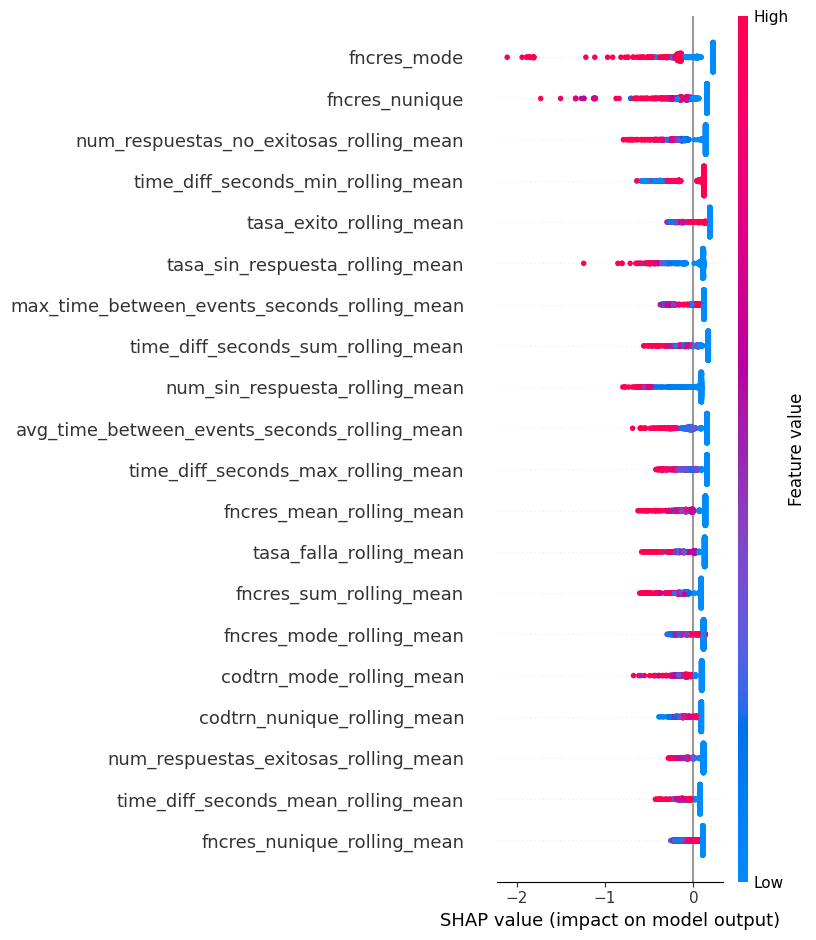

In [187]:
shap.summary_plot(shap_values, X_train_raw)


463


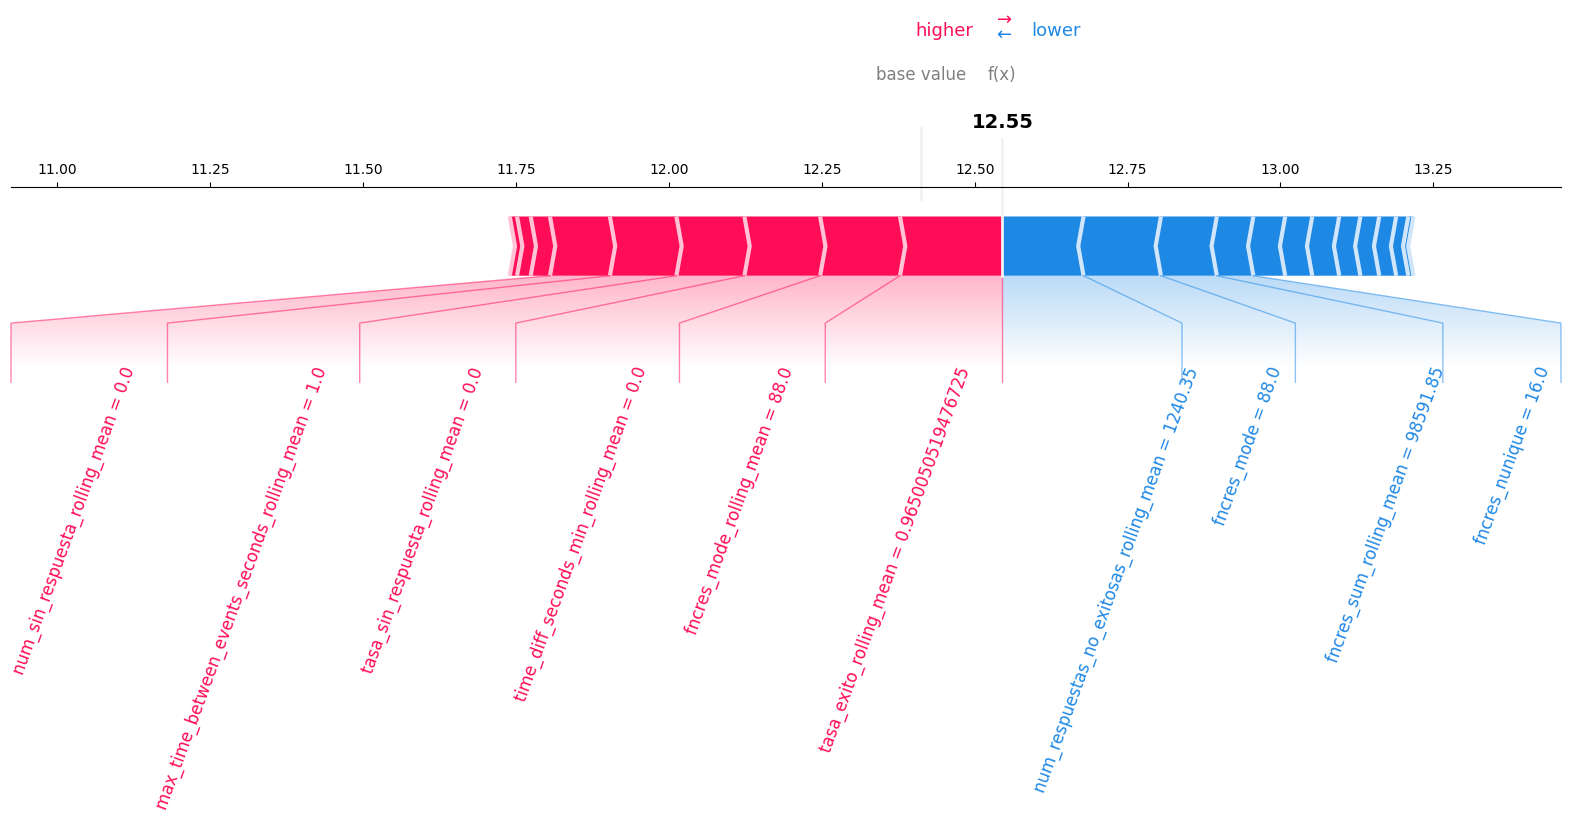

total_events_rolling_mean                       35408.500000
time_diff_seconds_mean_rolling_mean                 0.095565
time_diff_seconds_sum_rolling_mean               3385.750000
time_diff_seconds_min_rolling_mean                  0.000000
time_diff_seconds_max_rolling_mean                  4.150000
fncres_sum_rolling_mean                         98591.850000
fncres_mode_rolling_mean                           88.000000
fncres_nunique_rolling_mean                        17.300000
fncres_mean_rolling_mean                            2.782024
codtrn_mode_rolling_mean                          369.000000
codtrn_nunique_rolling_mean                        68.050000
num_respuestas_exitosas_rolling_mean            34168.150000
num_respuestas_no_exitosas_rolling_mean          1240.350000
num_sin_respuesta_rolling_mean                      0.000000
avg_time_between_events_seconds_rolling_mean        0.000821
min_time_between_events_seconds_rolling_mean        0.000000
max_time_between_events_

In [189]:
import shap
shap.initjs()

anomaly_index = 463
print(anomaly_index)
shap.force_plot(explainer.expected_value, shap_values[anomaly_index], X_train_raw.iloc[anomaly_index], matplotlib=True, link='identity', figsize=(20, 5),text_rotation=70)
rolling_mean_logs.iloc[anomaly_index]


583


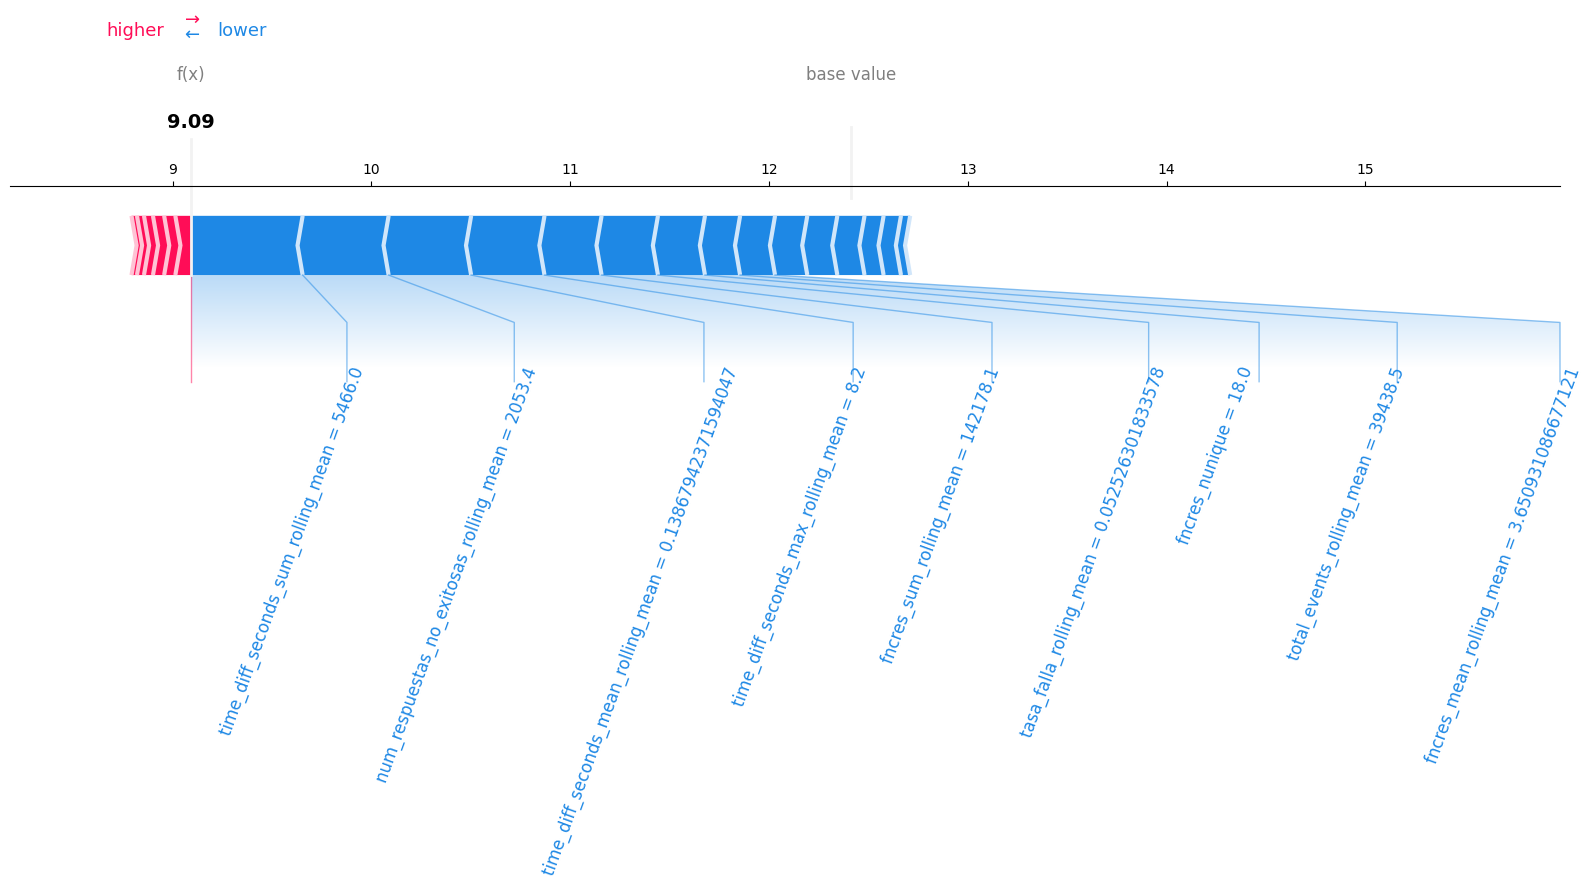

In [190]:
anomaly_index = 583
print(anomaly_index)
shap.force_plot(explainer.expected_value, shap_values[anomaly_index], X_train_raw.iloc[anomaly_index],  matplotlib=True, link='identity', figsize=(20, 5),text_rotation=70)

### RRCF

In [191]:
# Initialize the detector
rrcf_detector = sentinel.detectors.RRCFDetector(shingle_size=60)

# Get anomaly scores
anomaly_scores = rrcf_detector.fit_predict(rolling_mean_logs)

# Get anomalies with a threshold
anomalies = rrcf_detector.get_anomalies(threshold=np.percentile(anomaly_scores, 97))

# Print the results
print("Anomaly Scores:\n", anomaly_scores)
print("Anomalies:\n", anomalies)

Anomaly Scores:
 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
722     4.095242
723     4.078851
724     4.362898
725     6.190477
726    11.386984
Length: 727, dtype: float64
Anomalies:
 243     33.478307
244     62.120767
313     96.861202
314     27.610335
364     38.337566
427    218.786830
428     32.041161
484     34.230066
544     34.632936
604     37.725337
655     27.620044
656     29.425997
657     26.805623
658     28.445897
659     26.161001
660     25.049917
670     25.054569
671     25.008939
672     28.296756
673     33.484811
674     30.620375
675     29.938124
dtype: float64


In [192]:
df_rrcf = rolling_mean_logs.copy()
#df_rrcf = aggregate_logs.copy()
df_rrcf['scores'] = anomaly_scores.values
anomalies_index = df_rrcf.iloc[anomalies.index].index

In [193]:
df_rrcf.head()

,total_events_rolling_mean,time_diff_seconds_mean_rolling_mean,time_diff_seconds_sum_rolling_mean,time_diff_seconds_min_rolling_mean,time_diff_seconds_max_rolling_mean,fncres_sum_rolling_mean,fncres_mode_rolling_mean,fncres_nunique_rolling_mean,fncres_mean_rolling_mean,codtrn_mode_rolling_mean,...,num_sin_respuesta_rolling_mean,avg_time_between_events_seconds_rolling_mean,min_time_between_events_seconds_rolling_mean,max_time_between_events_seconds_rolling_mean,tasa_exito_rolling_mean,tasa_falla_rolling_mean,tasa_sin_respuesta_rolling_mean,fncres_mode,fncres_nunique,scores
2025-01-21 07:07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,3.0,0.0
2025-01-21 07:07:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,11.0,0.0
2025-01-21 07:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,12.0,0.0
2025-01-21 07:08:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,12.0,0.0
2025-01-21 07:09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,13.0,0.0


In [194]:
# Crear la figura
fig = go.Figure()

# Añadir la línea de puntuaciones de anomalías
fig.add_trace(go.Scatter(x=df_rrcf.index, y=df_rrcf['scores'], mode='lines+markers', name='Anomaly Scores', line=dict(color='blue'), marker=dict(size=5, opacity=0.4)))

# Añadir los puntos de anomalías
fig.add_trace(go.Scatter(x=anomalies_index, y=df_rrcf.loc[anomalies_index, 'scores'], mode='markers', name='Anomalies', marker=dict(color='red', size=8)))

# Resaltar el incidente entre las 12 pm y la 1 pm
fig.add_vrect(x0='2025-01-21 12:00:00', x1='2025-01-21 13:00:00', fillcolor='orange', opacity=0.3, layer='below', line_width=0, annotation_text='Incidente: App personas, Mi Bancolombia', annotation_position='top left')

# Configurar el layout
fig.update_layout(
    title='Puntajes de anomalías',
    xaxis_title='Time',
    yaxis_title='Anomaly Score',
    legend=dict(x=0.01, y=0.99)
)

# Mostrar la figura
fig.show()